# Logarithms
### Various numerical methods to calculate logarithms 


#### Standard power series
Start with the normal power series for $ln(1+t)$ (for $t\in(-1,1)$)

$\ln(1+t) = \sum_{n=1}^{\infty} \frac{(-1)^{n+1} t^n}{n} = t - \frac{t^2}{2} + \frac{t^3}{3} - \frac{t^4}{4} + \cdots  = t + \mathcal{O}(t^2)$

#### More cleverer power series:
Trick to increase to quadratic convergence: subtract all odd terms:

$$\begin{align}
\ln\left(\frac{1+t}{1-t} \right) = ln(1+t) - \ln(1-t) &= t - \frac{t^2}{2} + \frac{t^3}{3} - \frac{t^4}{4} +  \frac{t^5}{5} + \cdots \\
                     &+t + \frac{t^2}{2} + \frac{t^3}{3} + \frac{t^4}{4} +  \frac{t^5}{5} + \cdots \\
                    &= 2\left( t +          \frac{t^3}{3}              + \frac{t^5}{5} + \cdots \right) \\
                    &= 2t + \mathcal{O}(t^3)
\end{align}$$
Then set $x = \frac{1+t}{1-t}$, or, $t = \frac{x-1}{x+1} $, so a faster series for $\ln(x)$ is:
$$\begin{align}
\ln(x) = 2\left(\frac{x-1}{x+1}\right) + 2\frac{1}{3}\left(\frac{x-1}{x+1}\right)^3   + 2\frac{1}{5}\left(\frac{x-1}{x+1}\right)^5 + \cdots
\end{align}$$



#### Newton iteration on $f(y) = \exp(y) - x$
Note: Ensure that y > 0 to avoid the near zero derivative. This is done by setting x > 0 with the Factor trick.

$$\begin{align}
    y_{n+1} &= y_n - \frac{\exp(y_n) - x}{\exp(y_n)} \\ 
            &= y_n - (1 - x \exp(-y_n))
\end{align}$$

For more efficient computation: Use the approximate Newton method by approximating the Exp with its power series

$$\begin{align}
    \exp(-y) &\approx 1 - y + \frac{1}{2}y^2 - \frac{1}{3}y^3 + ... \\ 
            &\Rightarrow \\
    y_{n+1} &= y_n - 1 + x\left( 1 - y + \frac{1}{2}y_n^2 - \frac{1}{3}y_n^3 \right)  \\ 
\end{align}$$





In [213]:
from math import log, exp, sqrt # Only for accuracy calculation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np

import matplotlib 


In [214]:
def FactorTrick(x, xmin = .5, xmax=1.5):
    """ 
        Outputs xr and k such that 
            x = xr * 2^k with xr in xmin, xmax

        This allows for
        log(x) = log(xr) + k log(2), with xr in a better range for convergence
    """
    assert xmin * 2 <= xmax
    k = 0
    while x >= xmax:
        x = x/2
        k+=1
    while x <= xmin:
        x *= 2
        k -= 1
    return x, k

In [215]:

def LogSeries(x, max_iter=22, eps = 1e-16):
    """ Series calculation for Logarithm."""
    # Divisions: 1 + N
    # Mulitply: 1 + 2N
    info = {
        'iters'   : 0,
        'success' : False,
        'flops'   : 2,  # 2 flops for setup
    }
    y = 0 # running sum
    q = (x-1)/(x+1) # Quotient
    qq = q*q
    for n in range(max_iter):
        add = 2/(2*n+1) * q # 2 flops
        if abs(add) < eps:
            info['success'] = True
            break
        y += add
        q *= qq # 1 flop
        
        info['flops'] += 3 # 3 flops per iteration
        info['iters'] += 1

    info['res_iter'] = abs(add)
    info['res_actual'] = log(x) - y
    info['accuracy'] = float('inf') if log(x) == y else -log(abs(log(x) - y),10) # Number of correct digits in base-10
    return y, info



In [216]:
def LogNewton(x, max_iter=22, y = None, exp_approx = 4, good_initial_guess = False, eps = 1e-16):
    """ Approximate Newton iteration for Logarithm
        Zeros for the function:
            exp(y) - x
        Newton iteration with initial guess t0
            y1 = y0 - (exp(y0) - x) / exp(y0)
               = y0 - x exp(-y0) 
        Approximate the exp function with its series
            exp(-y0) = 1 -y0 + 1/2 y0^2 - 1/6 y0^3 + ... (3 flops per iteration)   
    """
    info = {
        'iters'   : 0,
        'success' : False,
        'flops'   : 1,  # flops for setup
        'res_iter': float('inf'),
    }

    def exp_series(y, n=exp_approx):
        # approximate exp(-y) with series expansion
        flops = 0
        exp_y = 1
        ynext = 1   # powers of y
        for j in range(1,n+1):
            ynext *= y / -j # Increase exponent, increase factorial denominator, swap sign
            exp_y += ynext
            flops += 2 # 2 flops per exp sum iteration
        return exp_y, flops

    if x < 1:
        info['warning'] = 'x<1. Poor performance on newton iteration.'
    if y is None: # No initial guess provided 
        y = 1  #Zeroth order guess
        if good_initial_guess: # Use first term of series approximation
            y = 2*(x-1)/(x+1)
            info['flops'] += 1 # One flop used for initial guess.
    for i in range(max_iter):
        exp_y, flops = exp_series(y)
        info['flops'] += 2 # 2 flops per exp sum iteration
            
        y1 = y - 1 + x*exp_y # Flops: 1
        info['flops'] += 1 # 1 flop per newton iteration
        info['iters'] += 1
        info['res_iter'] = abs(y1-y)
        if  info['res_iter'] < eps:
            # Start calculating root residuals if step size becomes small
            expminy, flops = exp_series(-y,exp_approx+1) # Calculate with one extra term on exp approximation
            info['flops'] += flops
            info['res_root'] = abs(expminy - x)
            if info['res_root'] < eps:
                info['success'] = True
                break
        y = y1

    info['res_actual'] = log(x) - y
    info['accuracy'] = float('inf') if log(x) == y else -log(abs(log(x) - y),10) # Number of correct digits in base-10

    return y, info



In [217]:
def LogSimpson(x, max_iters=22, **kwargs):
    """ Integrate 1/t in 0<t<x 
        Using Simpson's rule: (https://en.wikipedia.org/wiki/Simpson%27s_rule)
             b           b-a             a+b
            / f(x) dx ~= --- [ f(a) +4 f(---) + f(b) ]
           a              6               2
    """
    assert x > 1
    max_iters = max(1, max_iters)
    info = {
        'iters'   : max_iters, # Always run full segmentation, no break condition
        'success' : True, # no break condition, iteration always succeeds
        'flops'   : 1,  # 1 flop for setup
    }
    t = 1
    dt = (x-1) / max_iters # = b-a, segement length (flops: 1)
    dt2 = dt/2            # = (b-a) /2, segment midpoint
    y=0         # Running sum
    fa = 1      # =f(a)
    for i in range(max_iters):
        fm = 1/(t+dt2) # = f((a+b)/2), iterand at midpoint
        fb = 1/(t+dt)  # = f(b), iterand at right edge
        y += (fa + 4*fm + fb) # Add Simpson's rule on segment (a,b)
        # Shift over to next segment
        t+=dt
        fa = fb # Iterand at right becomes iterand at left 
        info['flops'] += 2 # two divisions

    # Scale
    y *= dt/6 
    info['flops'] += 1

    info['res_actual'] = log(x) - y
    info['accuracy'] = float('inf') if log(x) == y else -log(abs(log(x) - y),10) # Number of correct digits in base-10

    return y, info


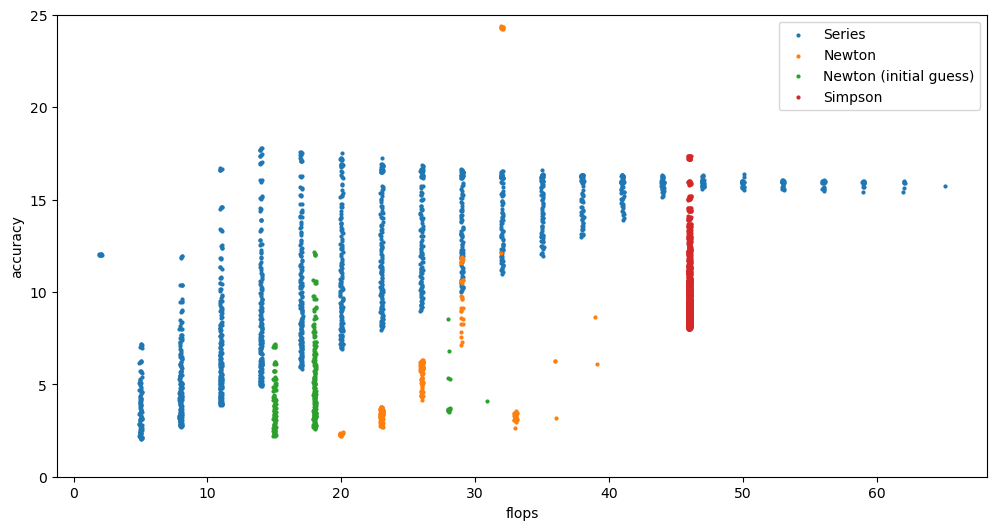

In [257]:

import random

def plot_scatter_flops_accuracy(add_jitter = True):

    if add_jitter:
        jitter = lambda : 1 - 2*random.random()
    else: 
        jitter = lambda : 0

    fig, (ax0) = plt.subplots(1, 1, figsize=(12, 6))


    xx = np.linspace(1+1e-12,2,100)
    epses = [10**(-i) for i in range(2,22,1)]

    funcs = {
        'Series' : lambda **kwargs : LogSeries(**kwargs),
        'Newton' : lambda **kwargs : LogNewton(**kwargs),
        'Newton (initial guess)' : lambda **kwargs : LogNewton(**kwargs, good_initial_guess=True),
        'Simpson': lambda **kwargs : LogSimpson(**kwargs),
        # 'Simpson (more segments)': lambda x : LogSimpson(x, max_iters=100),
    }
    for funcName, func in funcs.items():
        scatter_x = []
        scatter_y = []
        for eps in epses:
            for i,x in enumerate(xx):
                _, info = func(x=x, eps = eps)
                if info['success']:
                    scatter_x.append(info['flops'] + .1*jitter())
                    scatter_y.append(info['accuracy']+ .1*jitter())
        ax0.scatter(scatter_x, scatter_y, marker = 'o', label = funcName, s=4)
    ax0.legend(loc="upper right")
    ax0.set_xlabel("flops")
    ax0.set_ylabel("accuracy")

    ax0.set_ylim((0,25))


    plt.show()


plot_scatter_flops_accuracy()



In [219]:
def AGM(a,g, max_iters = 12, eps = 1e-16):
    info = {
        'iters':0,
        'success': False
    }
    for i in range(max_iters):
        a,g = (a+g)/2, sqrt(a*g)
        info['iters'] +=1
        if abs(a-g) < eps:
            info['success'] = True
            break
    info['res_iter'] = abs(a-g)
    return a, info


